In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import json

from scipy import integrate

comes from MEA Data 
MEA usage per month / MEA population * people per household
(10_808 * 1_000_000) / 7 / (5_104_476 + 388_920 + 254_375) * 3 

In [3]:
system_name = "T3 Technology_5kW"
egat_region = "Metropolitan"
monthly_consumption_kWh = 805.8776176016754 
tou = False
month = "July"
year = 2024
fit = 0
battery = 10

In [4]:
pv_system_folder = "PV Information"

for file in os.listdir(pv_system_folder):
    if system_name in file:
        with open(os.path.join(pv_system_folder, file), "r") as pv_system_info_file:
            pv_system_info = json.load(pv_system_info_file)

full_json = pv_system_info
full_json["battery"] = battery
full_json["egat region"] = egat_region
full_json["tou"] = tou
full_json["fit"] = fit

In [5]:
consumption_profile_folder = "Daily Consumption Profile"

tariff_consumption_threshold = 150
if tou:
    tariff_type = "1.3"
elif monthly_consumption_kWh <= tariff_consumption_threshold:
    tariff_type = "1.1"
else:
    tariff_type = "1.2"

for file in os.listdir(consumption_profile_folder):
    if tariff_type in file and "Unit" in file:
        consumption_profile_df = pd.read_csv(os.path.join(consumption_profile_folder, file))
        break

consumption_profile_df["Consumption"] = consumption_profile_df["Consumption"] * monthly_consumption_kWh
full_df = consumption_profile_df
full_json["tariff type"] = tariff_type
full_json["monthly consumption"] = monthly_consumption_kWh

In [6]:
generation_profile_folder = "Daily Generation Profile"

for file in os.listdir(generation_profile_folder):
    if "Unit" in file:
        generation_profile_df = pd.read_csv(os.path.join(generation_profile_folder, file))

egat_region = full_json["egat region"]

generation_profile_df["Generation"] = (
    generation_profile_df[egat_region] * full_json["monthly solar energy"]
)
generation_profile_df = generation_profile_df[["time", "Generation"]]

full_df["Generation"] = generation_profile_df["Generation"]

In [7]:
energy_saved_profile_df = pd.DataFrame(
    {
        "time": full_df["time"],
        "Energy saved": np.minimum(full_df["Consumption"], full_df["Generation"]),
    }
)
full_df["Energy saved"] = energy_saved_profile_df["Energy saved"]

energy_saved = integrate.trapezoid(
    energy_saved_profile_df["Energy saved"], energy_saved_profile_df["time"]
)
full_json["energy saved"] = energy_saved

In [8]:
battery_profile_arr = []
battery_from_grid_arr = []

battery_capacity = full_json["battery"] * 30.4375
on_peak_period = [9, 22]

if tou:
    for index, values in full_df.iterrows():
        if not on_peak_period[0] < values["time"] <= on_peak_period[1]: # Not in peak hour.
            if index == 0:
                battery_from_grid_arr.append(0)
                battery_profile_arr.append(battery_capacity)
                continue
            elif battery_profile_arr[-1] < battery_capacity:
                battery_from_grid_arr.append((battery_capacity - battery_profile_arr[-1]))
                battery_profile_arr.append(battery_capacity)
            else:
                battery_from_grid_arr.append(0)
                battery_profile_arr.append(battery_capacity)
        else: # During peak hour.
            if values["Generation"] - values["Consumption"] > 0:
                battery_from_grid_arr.append(0)
                battery_profile_arr.append(min([battery_profile_arr[-1] + (
                    values["Generation"] - values["Consumption"]
                )*0.5, battery_capacity]))
            else:
                battery_from_grid_arr.append(-min([battery_profile_arr[-1], values["Consumption"] - values["Generation"]]))
                battery_profile_arr.append(
                    max(
                        [
                            battery_profile_arr[-1]
                            - (values["Consumption"] - values["Generation"]),
                            0,
                        ]
                    )
                )
else:
    for index, values in full_df.iterrows():
        if index == 0:
            battery_from_grid_arr.append(0)
            battery_profile_arr.append(0)
            continue
        if values["Generation"] - values["Consumption"] > 0:
            battery_from_grid_arr.append(0)
            battery_profile_arr.append(min(battery_profile_arr[-1] + (values["Generation"] - values["Consumption"]), battery_capacity))
        else:
            battery_from_grid_arr.append(-min([battery_profile_arr[-1], values["Consumption"] - values["Generation"]]))
            battery_profile_arr.append(max(battery_profile_arr[-1] - (values["Consumption"] - values["Generation"]), 0))

battery_profile_df = pd.DataFrame(
    {
        "time": full_df["time"],
        "Battery": battery_profile_arr,
        "Battery from grid": battery_from_grid_arr
    }
)

full_df["Battery"] = battery_profile_df["Battery"]

full_df["Battery from grid"] = battery_profile_df["Battery from grid"]

battery_from_grid = integrate.trapezoid(full_df["Battery from grid"], full_df["time"])
full_json["battery from grid"] = battery_from_grid

In [9]:
initial_charge = 0
if tou:
    initial_charge = battery_capacity
charge_profile_arr = (
    full_df["Battery"] - np.insert(full_df["Battery"].to_numpy(), 0, initial_charge)[:-1]
)

battery_profile_df["Charge profile"] = charge_profile_arr
full_df["Charge profile"] = battery_profile_df["Charge profile"]

In [10]:
energy_sold_profile_df = pd.DataFrame({"time":full_df["time"]})

if pv_system_info["fit"]:
    energy_sold_profile_df["Energy sold"] = np.maximum(
        0, (full_df["Generation"] - full_df["Consumption"]).to_numpy()) - (full_df["Charge profile"] - full_df["Battery from grid"])
else:
    energy_sold_profile_df["Energy sold"] = np.zeros(full_df.shape[0])
full_df["Energy sold"] = energy_sold_profile_df["Energy sold"]

energy_sold = integrate.trapezoid(
    energy_sold_profile_df["Energy sold"], energy_sold_profile_df["time"]
)
full_json["Energy sold"] = energy_sold

In [11]:
net_consumption_df = pd.DataFrame(
    {
        "time": full_df["time"],
        "Net consumption": full_df["Consumption"]
        + full_df["Battery from grid"]
        - full_df["Energy saved"],
    }
)
full_df["Net consumption"] = net_consumption_df["Net consumption"]

net_consumption = integrate.trapezoid(full_df["Net consumption"], full_df["time"])
full_json["Net consumption"] = net_consumption

Text(0.5, 0, 'Time of Day (hour)')

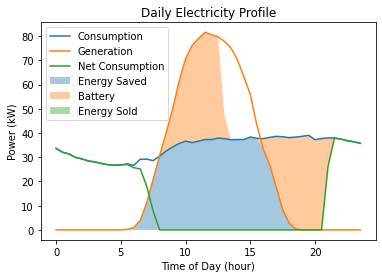

In [26]:
plt.plot(
    full_df["time"],
    full_df["Consumption"],
    label="Consumption",
)

plt.plot(
    full_df["time"],
    full_df["Generation"],
    label="Generation",
)

plt.plot(full_df["time"], full_df["Net consumption"], label="Net Consumption")

plt.fill_between(
    full_df["time"],
    full_df["Energy saved"],
    alpha=0.4,
    label="Energy Saved",
)

charge_profile = (
    full_df["Battery"] - np.insert(full_df["Battery"].to_numpy(), 0, 0)[:-1]
)
plt.fill_between(
    full_df["time"],
    full_df["Charge profile"] + full_df["Consumption"],
    full_df["Consumption"],
    alpha=0.4,
    label="Battery",
)

plt.fill_between(
    full_df["time"],
    full_df["Generation"] - full_df["Energy sold"],
    full_df["Generation"],
    alpha=0.4,
    label="Energy Sold",
)

if tou:
    plt.axvline(on_peak_period[0], color="red", linestyle="--")
    plt.axvline(on_peak_period[1], color="red", linestyle="--")

plt.legend()
plt.title("Daily Electricity Profile")
plt.ylabel("Power (kW)")
plt.xlabel("Time of Day (hour)")

In [13]:
def energy2cost_no_tou(monthly_consumption_kWh):
    cost = 0
    if monthly_consumption_kWh < tariff_consumption_threshold:
        cost += np.max([(np.min([15, monthly_consumption_kWh]) - 0) * 2.3488, 0])
        cost += np.max([(np.min([25, monthly_consumption_kWh]) - 15) * 2.9882, 0])
        cost += np.max([(np.min([35, monthly_consumption_kWh]) - 25) * 3.2405, 0])
        cost += np.max([(np.min([100, monthly_consumption_kWh]) - 35) * 3.6237, 0])
        cost += np.max([(np.min([150, monthly_consumption_kWh]) - 100) * 3.7171, 0])
    else:
        cost += np.max([(np.min([150, monthly_consumption_kWh]) - 0) * 3.2484, 0])
        cost += np.max([(np.min([400, monthly_consumption_kWh]) - 150) * 4.2218, 0])
        cost += np.max([(monthly_consumption_kWh - 400) * 3.2484, 0])
    return cost

def energy2cost_tou(consumption_profile, time_profile):
    cost = 0
    energy_off_peak = integrate.trapezoid(
        consumption_profile[: on_peak_period[0]], time_profile[: on_peak_period[0]]
    )
    energy_off_peak += integrate.trapezoid(
        consumption_profile[on_peak_period[1] :], time_profile[on_peak_period[1] :]
    )
    energy_on_peak = integrate.trapezoid(
        consumption_profile[on_peak_period[0] : on_peak_period[1]],
        time_profile[on_peak_period[0] : on_peak_period[1]],
    )
    cost += 5.7982 * energy_on_peak
    cost += 2.6369 * energy_off_peak
    return cost

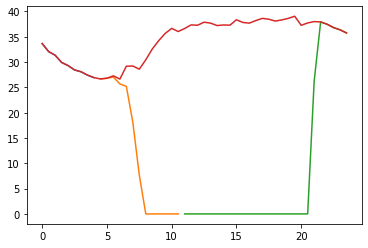

In [27]:
plt.plot(
    full_df["time"][: on_peak_period[0]],
    full_df["Net consumption"][: on_peak_period[0]],
)
plt.plot(
    full_df["time"][on_peak_period[0] : on_peak_period[1]],
    full_df["Net consumption"][on_peak_period[0] : on_peak_period[1]],
)
plt.plot(
    full_df["time"][on_peak_period[1] :],
    full_df["Net consumption"][on_peak_period[1] :],
)
plt.plot(full_df["time"], full_df["Consumption"])

-152.18750000000003


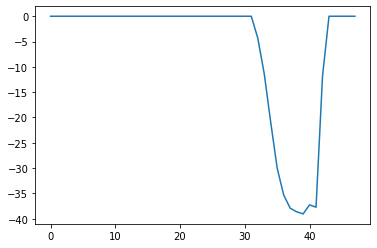

In [29]:
plt.plot(full_df["Battery from grid"])
print(integrate.trapezoid(full_df["Battery from grid"], full_df["time"]))

In [16]:
energy_off_peak = integrate.trapezoid(
    full_df["Net consumption"][: on_peak_period[0]+1],
    full_df["time"][: on_peak_period[0]+1],
)
energy_off_peak += integrate.trapezoid(
    full_df["Net consumption"][on_peak_period[1]-1 :],
    full_df["time"][on_peak_period[1]-1 :],
)
energy_on_peak = integrate.trapezoid(
    full_df["Net consumption"][on_peak_period[0] : on_peak_period[1]],
    full_df["time"][on_peak_period[0] : on_peak_period[1]],
)
print(energy_on_peak)
print(energy_off_peak)
print(energy_on_peak + energy_off_peak)

71.90830124294402
228.17756013734234
300.08586138028636


In [17]:
energy_off_peak = integrate.trapezoid(
    full_df["Consumption"][: on_peak_period[0]+1],
    full_df["time"][: on_peak_period[0]+1],
)
energy_off_peak += integrate.trapezoid(
    full_df["Consumption"][on_peak_period[1]-1:],
    full_df["time"][on_peak_period[1]-1 :],
)
energy_on_peak = integrate.trapezoid(
    full_df["Consumption"][on_peak_period[0] : on_peak_period[1]],
    full_df["time"][on_peak_period[0] : on_peak_period[1]],
)
print(energy_on_peak)
print(energy_off_peak)
print(energy_on_peak+energy_off_peak)

184.32952187408742
621.548095727587
805.8776176016744


In [18]:
monthly_consumption_kWh

805.8776176016754

In [19]:
integrate.trapezoid((full_df["Net consumption"]-full_df["Consumption"])[on_peak_period[0]:on_peak_period[1]], full_df["time"][on_peak_period[0]:on_peak_period[1]])

-112.4212206311434

In [20]:
365.25/12

30.4375

In [21]:
# Convert energy saved to money saved
money_saved = 0

if tou:
    original_price = energy2cost_tou(full_df["Consumption"], full_df["time"])
    new_price = energy2cost_tou(full_df["Net consumption"], full_df["time"])
    money_saved = original_price - new_price
else:
    original_price = energy2cost_no_tou(monthly_consumption_kWh)
    new_price = energy2cost_no_tou(
        integrate.trapezoid(full_df["Net consumption"], full_df["time"])
    )
    money_saved = original_price - new_price

full_json["money saved"] = money_saved

In [22]:
money_sold = 0

if full_json["fit"]:
    money_sold += energy_sold * 2.2

full_json["money sold"] = money_sold

In [23]:
total_gain = money_saved + money_sold
full_json["total gain"] = total_gain

In [24]:
total_gain * 12 * 0.031

647.3805752004201

In [25]:
10 * 365.25 / 12 * (5.7982 - 2.6369) * 12 * 0.031

357.9460957499999